In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import time
import pickle
from timeit import Timer
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import lightgbm
from keras.callbacks import ModelCheckpoint, EarlyStopping
import re
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, average_precision_score, recall_score , fbeta_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import shap
# pour afficher les graphiques de shap dans le notebook
shap.initjs()

# Importation des données

In [110]:
data_train = pd.read_csv('data_train.csv')

In [111]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149997 entries, 0 to 149996
Data columns (total 85 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   TOTALAREA_MODE                                 149997 non-null  float64
 1   REG_CITY_NOT_WORK_CITY                         149997 non-null  float64
 2   REG_CITY_NOT_LIVE_CITY                         149997 non-null  float64
 3   REGION_RATING_CLIENT_W_CITY                    149997 non-null  float64
 4   REGION_RATING_CLIENT                           149997 non-null  float64
 5   REGION_POPULATION_RELATIVE                     149997 non-null  float64
 6   PREV_PRODUCT_COMBINATION_CardStreet_MEAN       149997 non-null  float64
 7   PREV_NAME_CONTRACT_STATUS_Approved_MEAN        149997 non-null  float64
 8   PREV_HOUR_APPR_PROCESS_START_MEAN              149997 non-null  float64
 9   PREV_DAYS_DECISION_MEAN              

In [112]:
data_train.head(5)

,TOTALAREA_MODE,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_DAYS_DECISION_MEAN,...,APPROVED_AMT_ANNUITY_MEAN,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,AMT_REQ_CREDIT_BUREAU_QRT,AMT_GOODS_PRICE,AMT_ANNUITY,ACTIVE_DAYS_CREDIT_MEAN,SK_ID_CURR,TARGET
0,0.0149,0.0,0.0,2.0,2.0,0.018801,0.0,1.0,12.333333,-670.666667,...,10358.6850,0.0252,0.0250,0.0247,0.0,351000.0,24700.5,-537.0,100002,1.0
1,0.0714,0.0,0.0,1.0,1.0,0.003541,0.0,1.0,12.333333,-670.666667,...,10358.6850,0.0924,0.0968,0.0959,0.0,1129500.0,35698.5,-537.0,100003,0.0
2,0.0691,0.0,0.0,2.0,2.0,0.010032,0.0,1.0,12.333333,-670.666667,...,10358.6850,0.0840,0.0874,0.0887,0.0,135000.0,6750.0,-537.0,100004,0.0
3,0.0691,0.0,0.0,2.0,2.0,0.008019,0.0,1.0,15.000000,-181.000000,...,24246.0000,0.0840,0.0874,0.0887,0.0,297000.0,29686.5,-537.0,100006,0.0
4,0.0691,1.0,0.0,2.0,2.0,0.028663,0.0,1.0,13.500000,-866.000000,...,14760.2925,0.0840,0.0874,0.0887,0.0,513000.0,21865.5,-537.0,100007,0.0


## Split & Sampling

In [113]:
X_train, X_test, y_train, y_test = train_test_split(data_train.drop(['TARGET','SK_ID_CURR'], axis = 1),
                                                    data_train['TARGET'],
                                                    test_size=0.3, random_state=42)

In [114]:
print('Etat des datasets sans sampling')
print('train :', X_train.shape, y_train.shape)
print('test :', X_test.shape, y_test.shape)
print(y_train.value_counts())
print('Le taux de 1 dans y_train : ' + str(round(((y_train == 1.).sum() / y_train.shape[0] *100),2))+"%")
print('Le taux de 1 dans y_test : ' + str(round(((y_test == 1.).sum() / y_test.shape[0] *100),2))+"%")

Etat des datasets sans sampling
train : (104997, 83) (104997,)
test : (45000, 83) (45000,)
0.0    96326
1.0     8671
Name: TARGET, dtype: int64
Le taux de 1 dans y_train : 8.26%
Le taux de 1 dans y_test : 7.96%


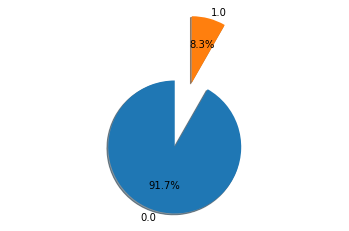

In [115]:
count_1 = round(((y_train == 1.).sum() / y_train.shape[0] *100),2)
count_2 = 100-count_1
choix=y_train.value_counts() 
labels=choix.index
fig, ax = plt.subplots()
explode = (0, 1.) 
ax.pie(choix, labels=labels,autopct='%1.1f%%',shadow=True, explode = explode, startangle=90)
ax.axis('equal')
plt.show()

In [116]:
# Include oversampling/undersampling/smote methods only on training   
# Over-Sampling":
ros = RandomOverSampler(random_state=2)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [117]:
print('Etat des datasets avec RandomOverSampler')
print('train :', X_train_ros.shape, y_train_ros.shape)
print('test :', X_test.shape, y_test.shape)
print(y_train_ros.value_counts())
print('Le taux de 1 dans y_train : ' + str(round(((y_train_ros == 1.).sum() / y_train_ros.shape[0] *100),2))+"%")

Etat des datasets avec RandomOverSampler
train : (192652, 83) (192652,)
test : (45000, 83) (45000,)
0.0    96326
1.0    96326
Name: TARGET, dtype: int64
Le taux de 1 dans y_train : 50.0%


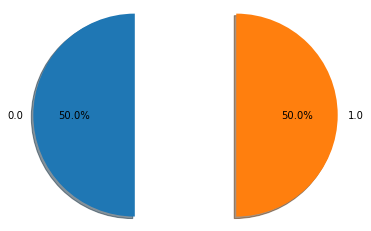

In [118]:
count_1 = round(((y_train_ros == 1.).sum() / y_train_ros.shape[0] *100),2)
count_2 = 100-count_1
choix=y_train_ros.value_counts() 
labels=choix.index
fig, ax = plt.subplots()
explode = (0, 1.) 
ax.pie(choix, labels=labels,autopct='%1.1f%%',shadow=True, explode = explode, startangle=90)
ax.axis('equal')
plt.show()

In [119]:
# Under-Sampling
rus = RandomUnderSampler(random_state=2)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [120]:
print('Etat des datasets avec RandomUnderSampler')
print('train :', X_train_rus.shape, y_train_rus.shape)
print('test :', X_test.shape, y_test.shape)
print(y_train_rus.value_counts())
print('Le taux de 1 dans y_train : ' + str(round(((y_train_rus == 1.).sum() / y_train_rus.shape[0] *100),2))+"%")

Etat des datasets avec RandomUnderSampler
train : (17342, 83) (17342,)
test : (45000, 83) (45000,)
0.0    8671
1.0    8671
Name: TARGET, dtype: int64
Le taux de 1 dans y_train : 50.0%


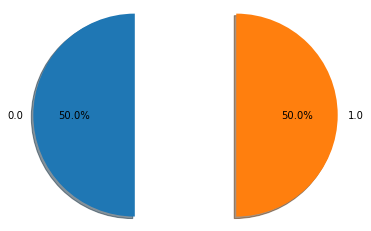

In [121]:
count_1 = round(((y_train_rus == 1.).sum() / y_train_rus.shape[0] *100),2)
count_2 = 100-count_1
choix=y_train_rus.value_counts() 
labels=choix.index
fig, ax = plt.subplots()
explode = (0, 1.) 
ax.pie(choix, labels=labels,autopct='%1.1f%%',shadow=True, explode = explode, startangle=90)
ax.axis('equal')
plt.show()

In [122]:
# Smote
sm = SMOTE(random_state=2)
X_train_sm, y_train_sm = rus.fit_resample(X_train, y_train)

In [123]:
print('Etat des datasets avec SMOTE')
print('train :', X_train_sm.shape, y_train_sm.shape)
print('test :', X_test.shape, y_test.shape)
print(y_train_sm.value_counts())
print('Le taux de 1 dans y_train : ' + str(round(((y_train_sm == 1.).sum() / y_train_sm.shape[0] *100),2))+"%")

Etat des datasets avec SMOTE
train : (17342, 83) (17342,)
test : (45000, 83) (45000,)
0.0    8671
1.0    8671
Name: TARGET, dtype: int64
Le taux de 1 dans y_train : 50.0%


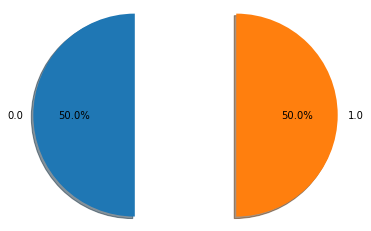

In [124]:
count_1 = round(((y_train_sm == 1.).sum() / y_train_sm.shape[0] *100),2)
count_2 = 100-count_1
choix=y_train_sm.value_counts() 
labels=choix.index
fig, ax = plt.subplots()
explode = (0, 1.) 
ax.pie(choix, labels=labels,autopct='%1.1f%%',shadow=True, explode = explode, startangle=90)
ax.axis('equal')
plt.show()

## Models

In [125]:
models = [LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1),
          RandomForestClassifier(max_depth=2, random_state=0)]


In [126]:
models

[LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
                min_child_weight=39.3259775, min_split_gain=0.0222415,
                n_estimators=10000, nthread=4, num_leaves=34,
                reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
                subsample=0.8715623, verbose=-1),
 RandomForestClassifier(max_depth=2, random_state=0)]

In [180]:
def train_models(model, X_train, X_test, y_train, y_test,beta=3):
    model.fit(X_train, y_train)
    steps = {
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
        'Accuracy': accuracy_score(y_test, model.predict(X_test)),
        'Precision': precision_score(y_test, model.predict(X_test)),
        'Recall': recall_score(y_test, model.predict(X_test)),
        'F1': f1_score(y_test, model.predict(X_test), labels=None, pos_label=1, average='binary')
    }
          
    return steps

In [181]:
def steps_models(models=models,sampling_method=False):
    name = []
    auc = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    time_ = []

    for model in models:
        start = time.time()
        if sampling_method == "smote":
            results = train_models(model, X_train_sm, X_test, y_train_sm, y_test)
        elif sampling_method == "oversampling":
            ros = RandomOverSampler(random_state=2)
            results = train_models(model, X_train_ros, X_test, y_train_ros, y_test)
        elif sampling_method == "undersampling":
            rus = RandomUnderSampler(random_state=2)
            results = train_models(model, X_train_rus, X_test, y_train_rus, y_test)
        else:
            results = train_models(model, X_train, X_test, y_train, y_test)

        name.append(type(model).__name__)
        auc.append(results['AUC'])
        accuracy.append(results['Accuracy'])
        precision.append(results['Precision'])
        recall.append(results['Recall'])
        f1.append(results['F1'])
        time_.append(time.time()-start)
        

    #Initialise data of lists
    
    res_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
    res_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
    res_models.sort_values('AUC', ascending=False, inplace=True)
    
    return res_models

In [182]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances=False):
    '''Cette fonction fera des graphiques, une matrice de confusion (sklearn) utilisant Seaborn heatmap 
    visualization  et une courbe ROC.'''
    
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
        features = []
        for i in range(20):
            features.append(X_train.columns[indices[i]])

        sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
        plt.xlabel('Features importance')
        plt.xticks(rotation=90)
    
    plt.show()

## Modèles Sans Sampling

In [183]:
rmo = steps_models(models=models,sampling_method=False)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [184]:
rmo

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.738292,0.918733,0.421053,0.055835,0.098595,346.813152
1,RandomForestClassifier,0.716838,0.9204,0.0,0.0,0.0,6.447446


### Meilleurs modèles basés sur AUC

In [185]:
top = LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
top.fit(X_train, y_train)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

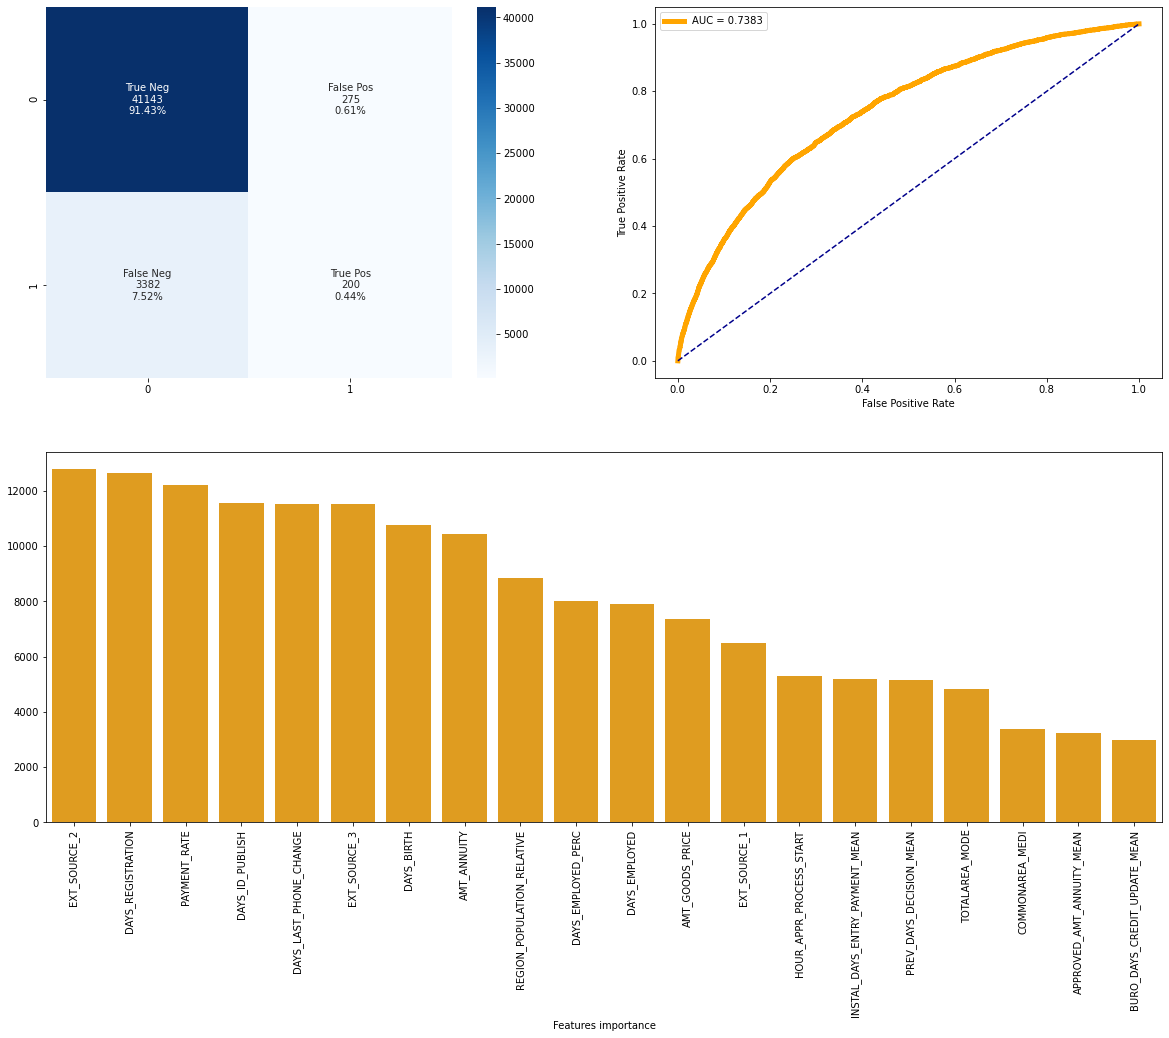

In [186]:
cf_matrix_roc_auc(top, y_test, top.predict(X_test), top.predict_proba(X_test)[:,1],feature_importances=True)

### Meilleurs modèles basés sur le Temps

In [187]:
top_time = RandomForestClassifier(max_depth=2, random_state=0)
top_time.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

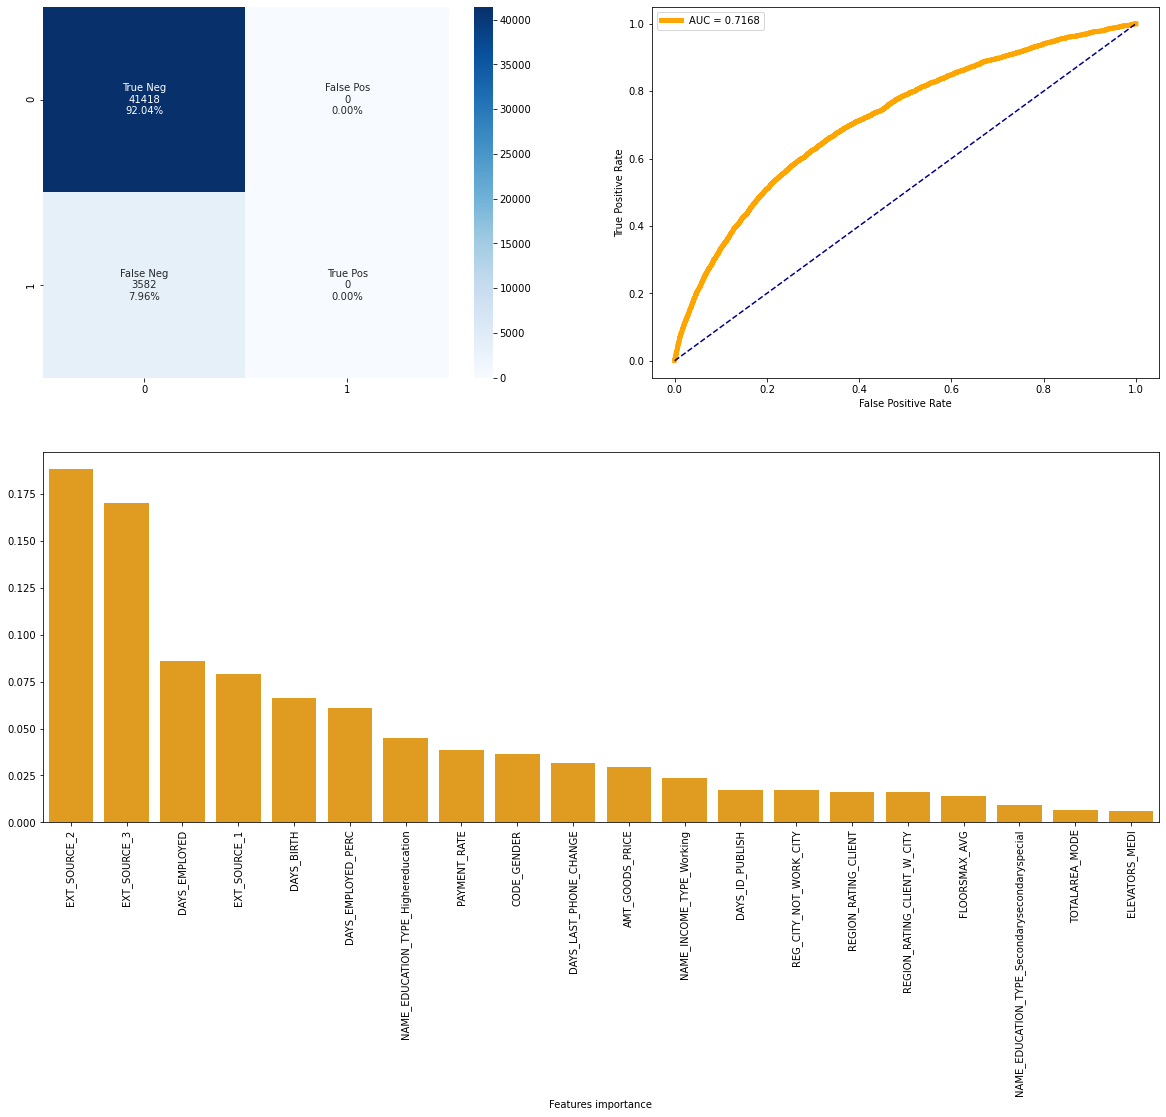

In [188]:
cf_matrix_roc_auc(top_time, y_test, top_time.predict(X_test), top_time.predict_proba(X_test)[:,1],feature_importances=True)

## Modèles Avec SMOTE

In [189]:
resm = steps_models(models=models,sampling_method="smote")

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [190]:
resm

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.731003,0.672911,0.149934,0.665829,0.244753,245.048705
1,RandomForestClassifier,0.7185,0.667956,0.147599,0.664154,0.241523,2.349354


### Meilleurs modèles basés sur AUC

In [191]:
top_sm = LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
top_sm.fit(X_train_sm, y_train_sm)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

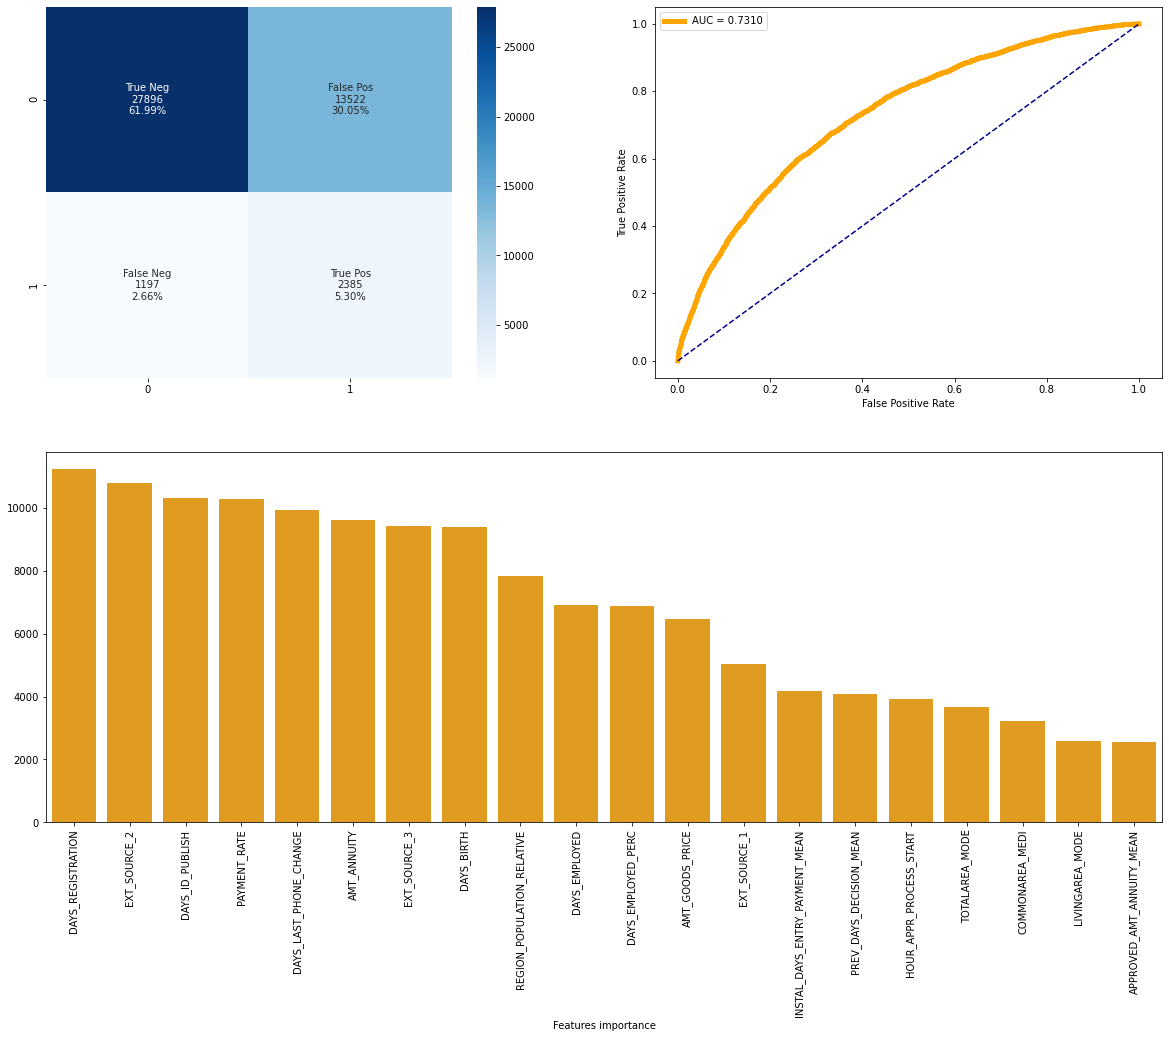

In [192]:
cf_matrix_roc_auc(top_sm, y_test, top_sm.predict(X_test), top_sm.predict_proba(X_test)[:,1],feature_importances=True)

### Meilleurs modèles basés sur le Temps

In [193]:
top_time_sm = RandomForestClassifier(max_depth=2, random_state=0)
top_time_sm.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=2, random_state=0)

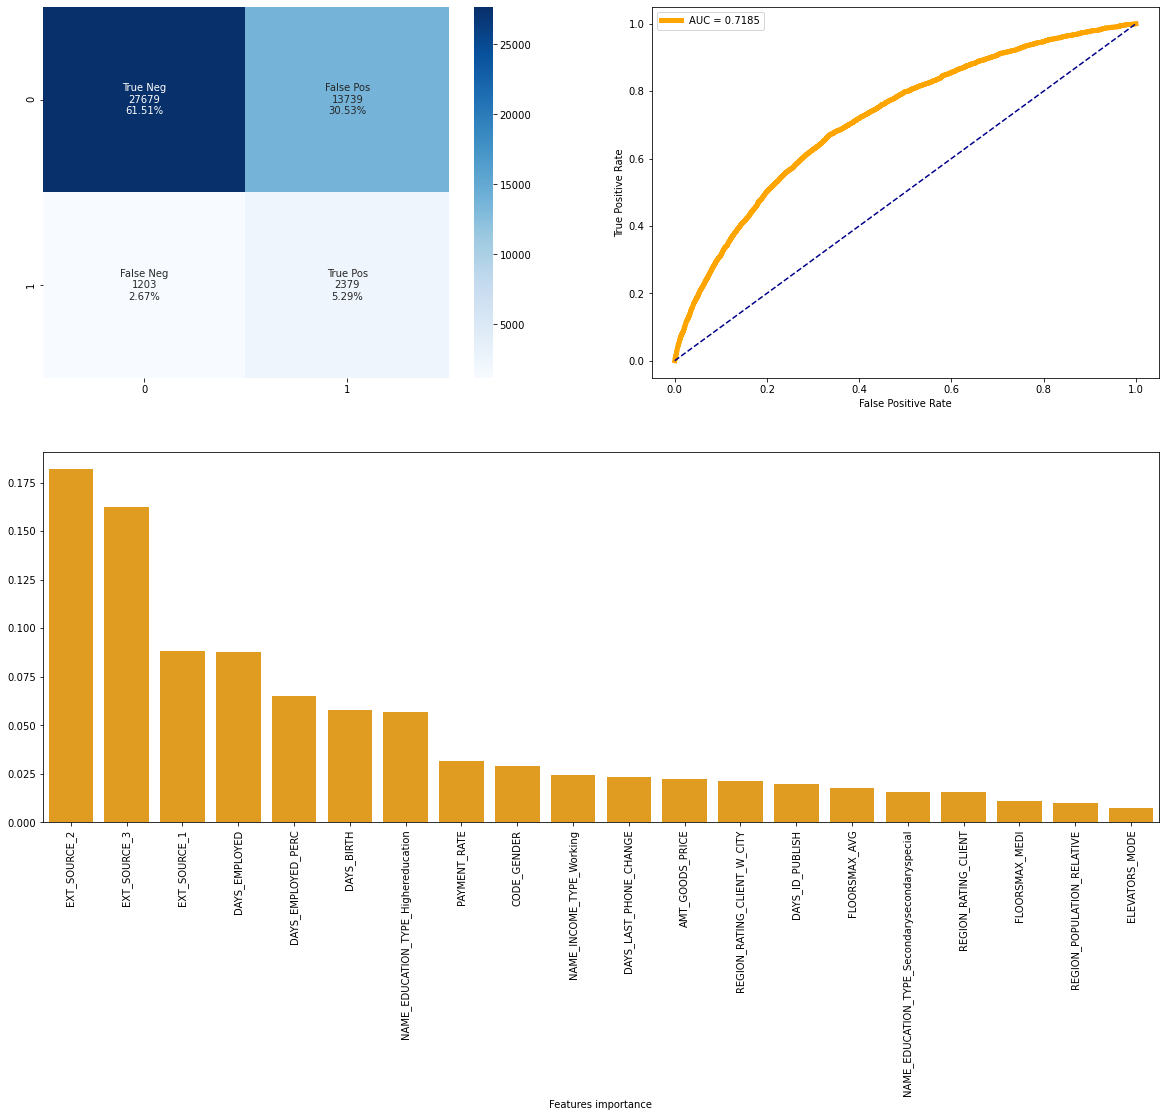

In [194]:
cf_matrix_roc_auc(top_time_sm, y_test, top_time_sm.predict(X_test), top_time_sm.predict_proba(X_test)[:,1],feature_importances=True)

## Modèles Avec Under-Sampling

In [195]:
rerus = steps_models(models=models,sampling_method="undersampling")

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [196]:
rerus

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.731003,0.672911,0.149934,0.665829,0.244753,231.484086
1,RandomForestClassifier,0.7185,0.667956,0.147599,0.664154,0.241523,2.150103


### Meilleurs modèles basés sur AUC

In [197]:
top_rus = LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
top_rus.fit(X_train_rus, y_train_rus)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

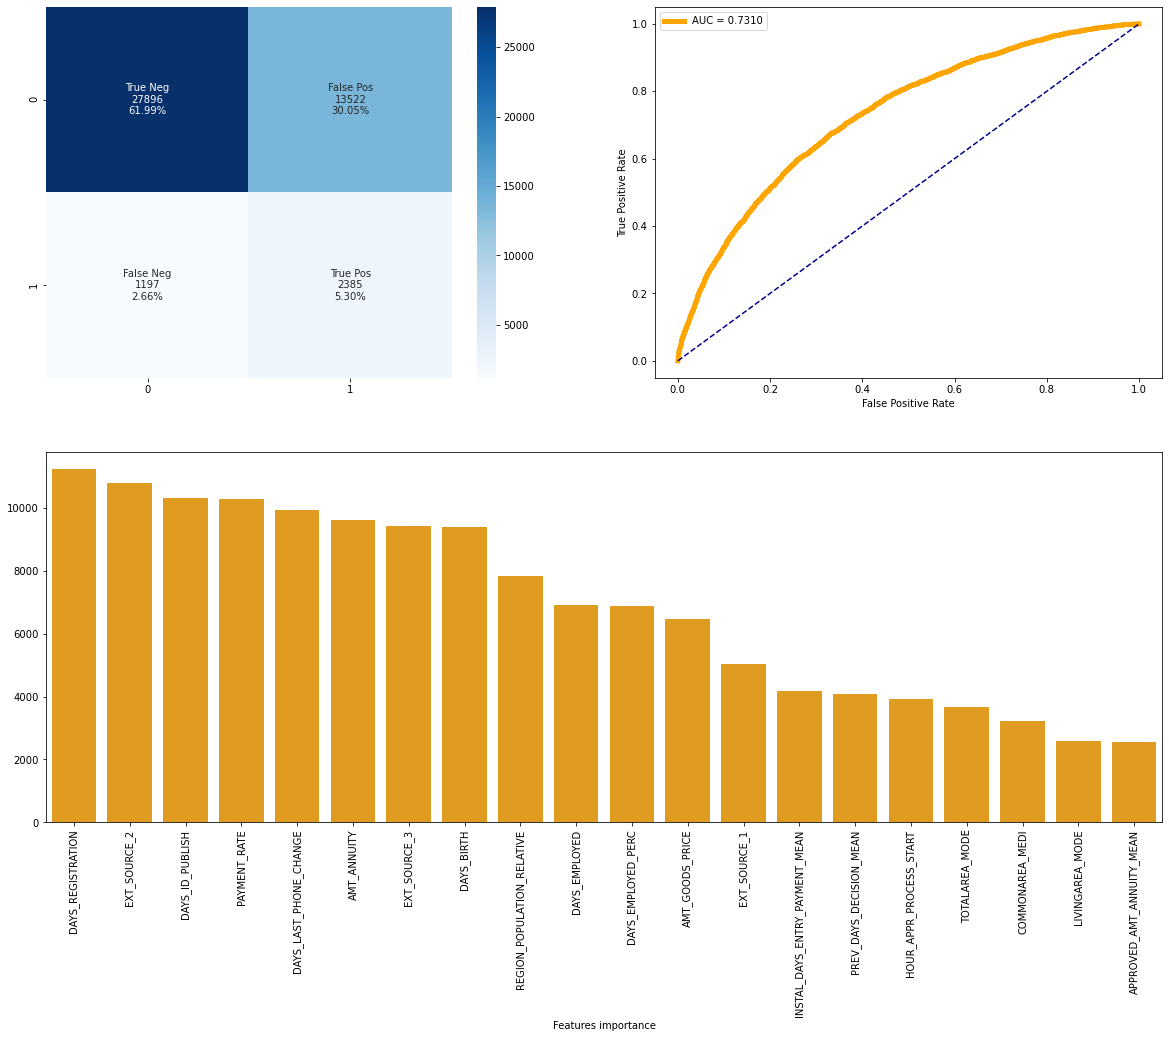

In [198]:
cf_matrix_roc_auc(top_rus, y_test, top_rus.predict(X_test), top_rus.predict_proba(X_test)[:,1],feature_importances=True)

### Meilleurs modèles basés sur le Temps

In [199]:
top_time_rus = RandomForestClassifier(max_depth=2, random_state=0)
top_time_rus.fit(X_train_rus, y_train_rus)

RandomForestClassifier(max_depth=2, random_state=0)

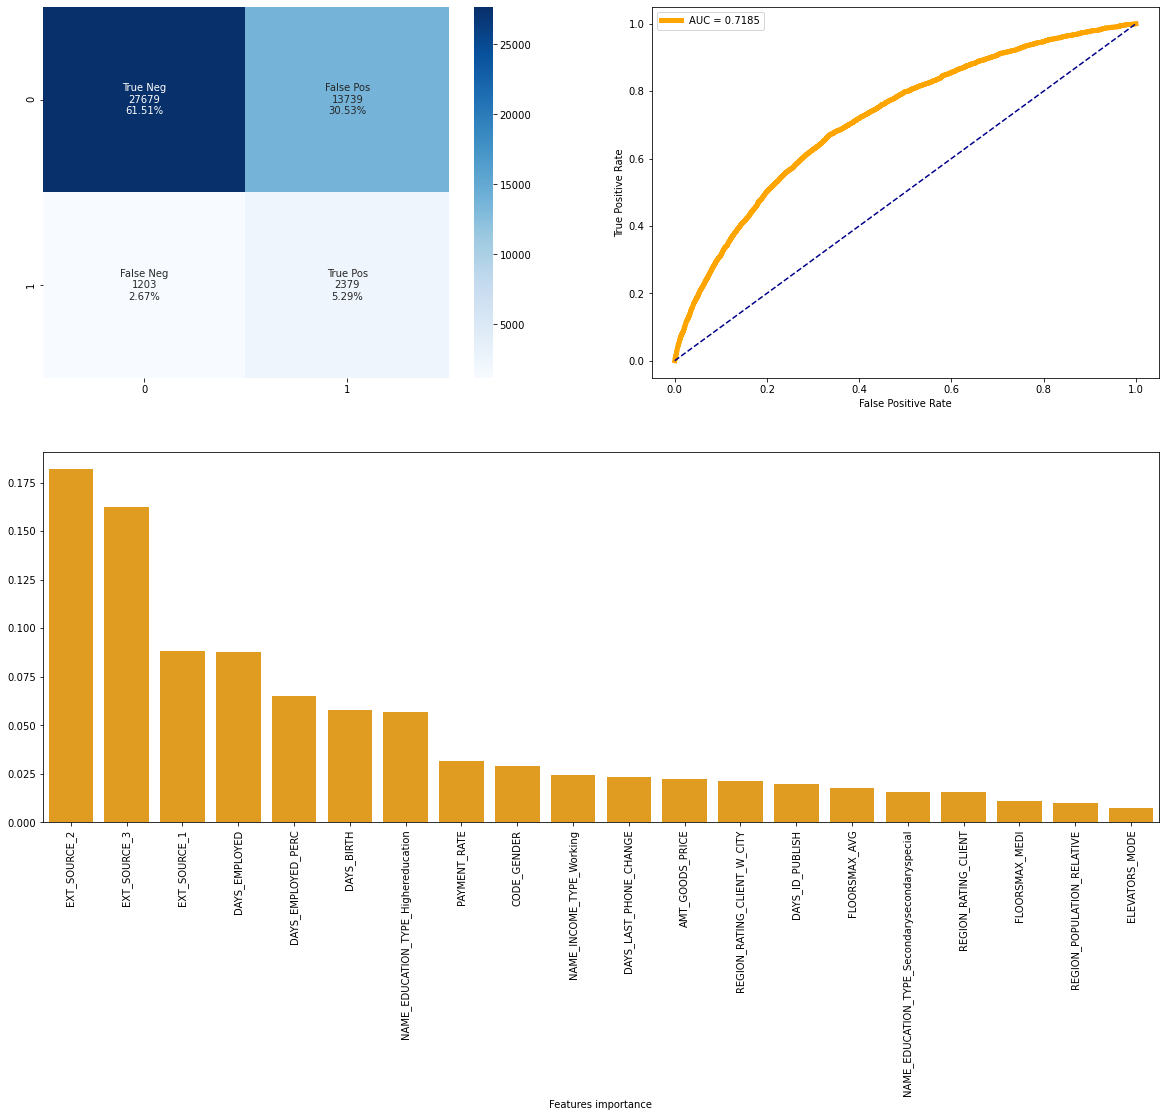

In [200]:
cf_matrix_roc_auc(top_time_rus, y_test, top_time_rus.predict(X_test), top_time_rus.predict_proba(X_test)[:,1],feature_importances=True)

## Modèles Avec Over-Sampling

In [201]:
reros = steps_models(models=models,sampling_method="oversampling")

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [202]:
reros

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.729374,0.8708,0.246017,0.301787,0.271063,528.730611
1,RandomForestClassifier,0.715272,0.659867,0.144123,0.662758,0.236761,10.591672


### Meilleurs modèles basés sur AUC

In [203]:
top_ros = LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
top_ros.fit(X_train_ros, y_train_ros)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

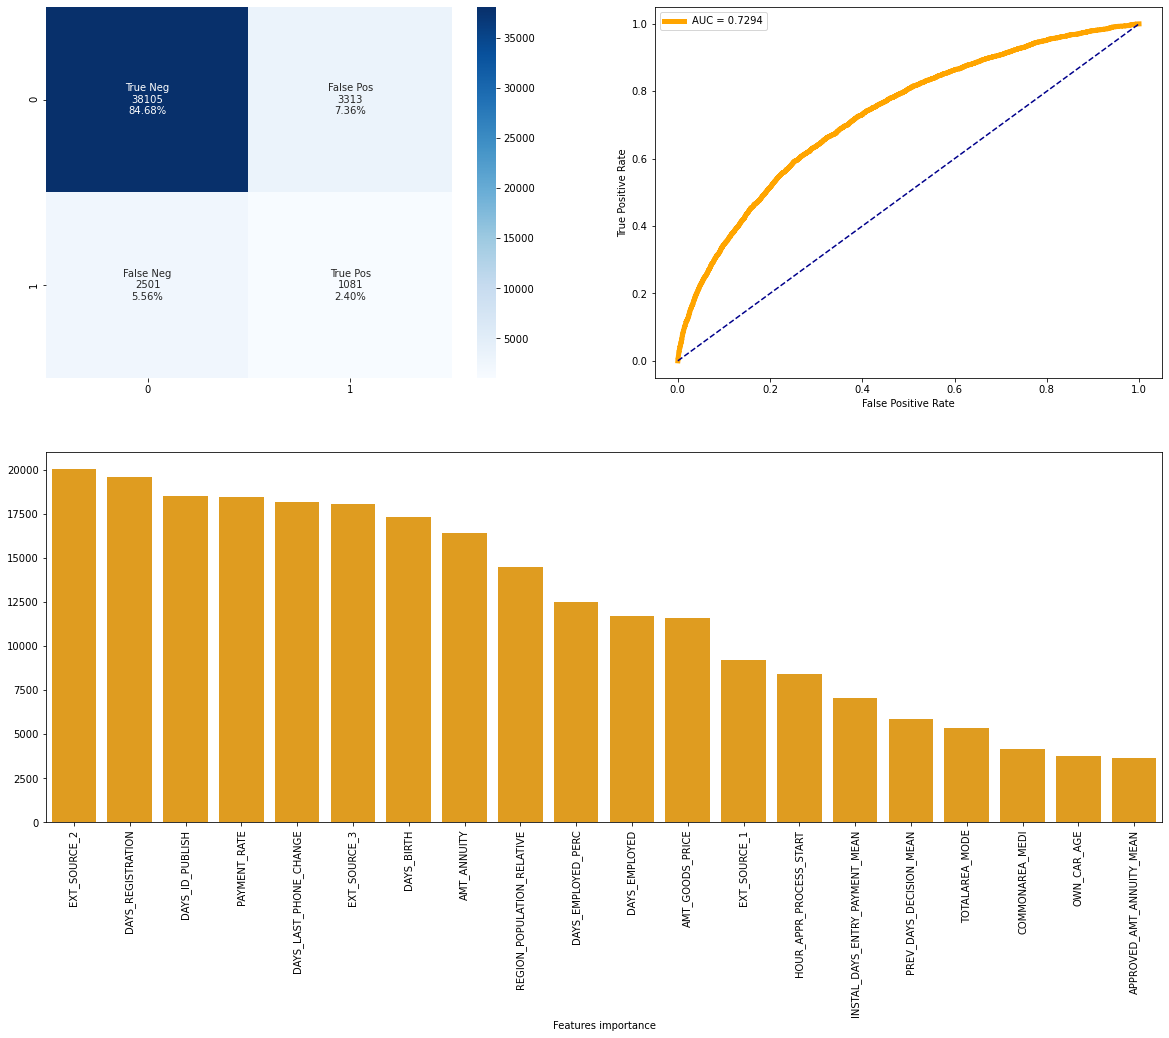

In [204]:
cf_matrix_roc_auc(top_ros, y_test, top_ros.predict(X_test), top_ros.predict_proba(X_test)[:,1],feature_importances=True)

### Meilleurs modèles basés sur le Temps

In [205]:
top_time_ros = RandomForestClassifier(max_depth=2, random_state=0)
top_time_ros.fit(X_train_ros, y_train_ros)

RandomForestClassifier(max_depth=2, random_state=0)

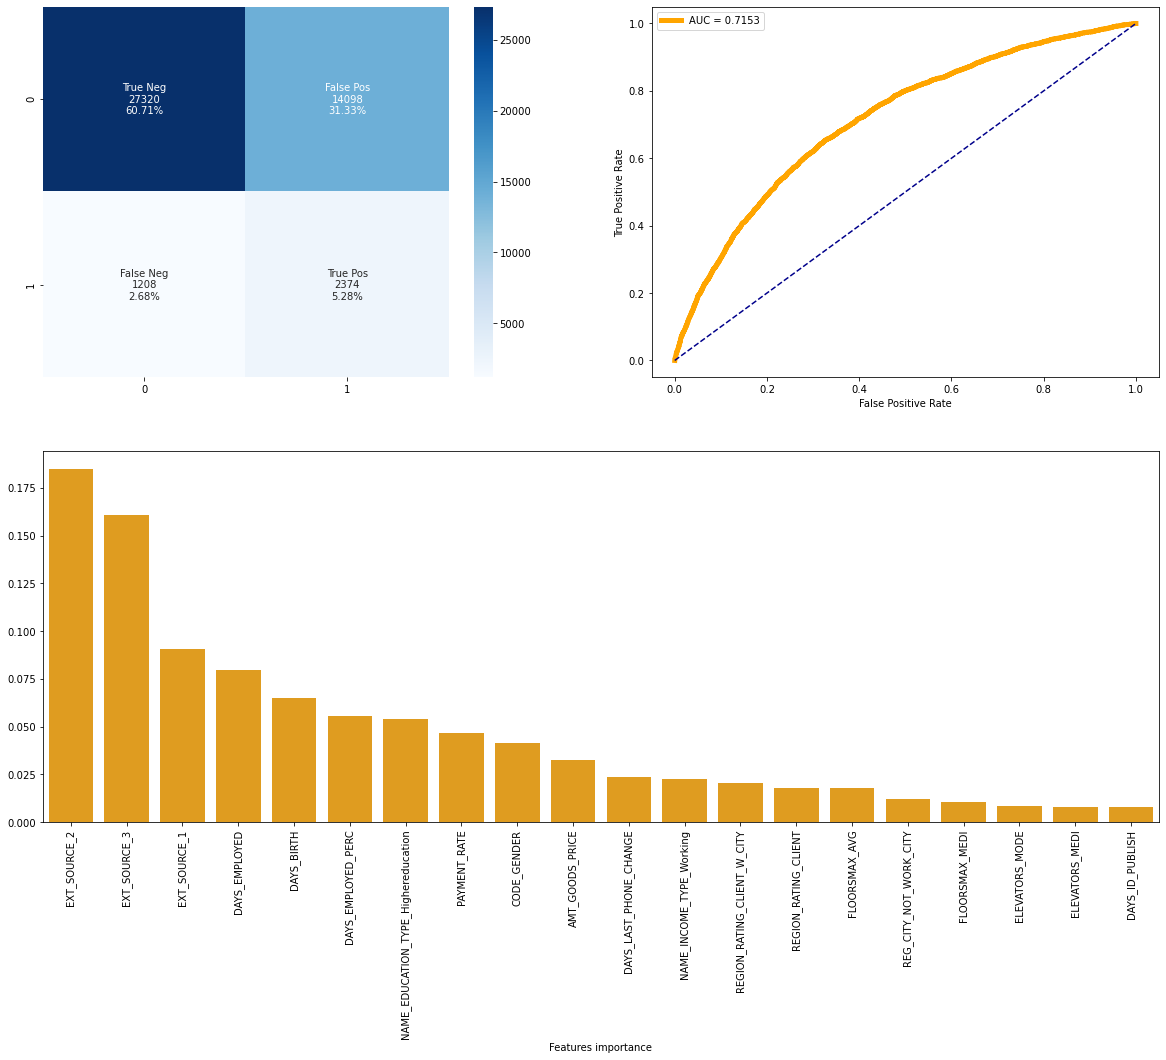

In [206]:
cf_matrix_roc_auc(top_time_ros, y_test, top_time_ros.predict(X_test), top_time_ros.predict_proba(X_test)[:,1],feature_importances=True)

## Choix & Optimisation du  modele de prédiction

> Notre choix s'est orienté vers RandomForestClassifier, on priorise le temps de traitement "**Time**". On choisit également l'underSampling pour son temps de traitement plus rapide que les autres techniques de "Sampling".

In [207]:
best_model = RandomForestClassifier()

In [208]:
# Optimisation
param_grid = { 
    'n_estimators': [10,15,20],
    'max_depth' : [2,4,6],
    'random_state': [0,42],
    'max_samples' : [.15,.3,.45]
}

In [209]:
scor_mat = make_scorer(f1_score,bestscore=True)

In [210]:
grid = GridSearchCV(estimator=best_model,param_grid=param_grid,cv=5,scoring=scor_mat)

In [211]:
grid.fit(X_train_rus, y_train_rus)

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
TypeError: f1_score() got an unexpected keyword argument 'bestscore'

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/saidmazzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = s

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'max_samples': [0.15, 0.3, 0.45],
                         'n_estimators': [10, 15, 20],
                         'random_state': [0, 42]},
             scoring=make_scorer(f1_score, bestscore=True))

In [212]:
grid.best_params_

{'max_depth': 2, 'max_samples': 0.15, 'n_estimators': 10, 'random_state': 0}

#### Optimisation du modèle

In [213]:
top_models = [LGBMClassifier(
            #boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            #subsample=1,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1),
          RandomForestClassifier(max_depth=2,max_samples = 0.15, n_estimators = 10, random_state=0)]


In [214]:
model_rfc = RandomForestClassifier(n_estimators=10,max_samples=0.15,max_depth=2,random_state=0)

In [215]:
model_rfc.fit(X_train_rus, y_train_rus)

RandomForestClassifier(max_depth=2, max_samples=0.15, n_estimators=10,
                       random_state=0)

In [216]:
top_mod_rus = steps_models(models=top_models,sampling_method="undersampling")
#rfc_rus = steps_models(models=model_rfc,sampling_method="undersampling")

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1


In [217]:
#rfc_rus
top_mod_rus

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.731003,0.672911,0.149934,0.665829,0.244753,184.782063
1,RandomForestClassifier,0.700338,0.6688,0.142839,0.632049,0.233018,0.411472


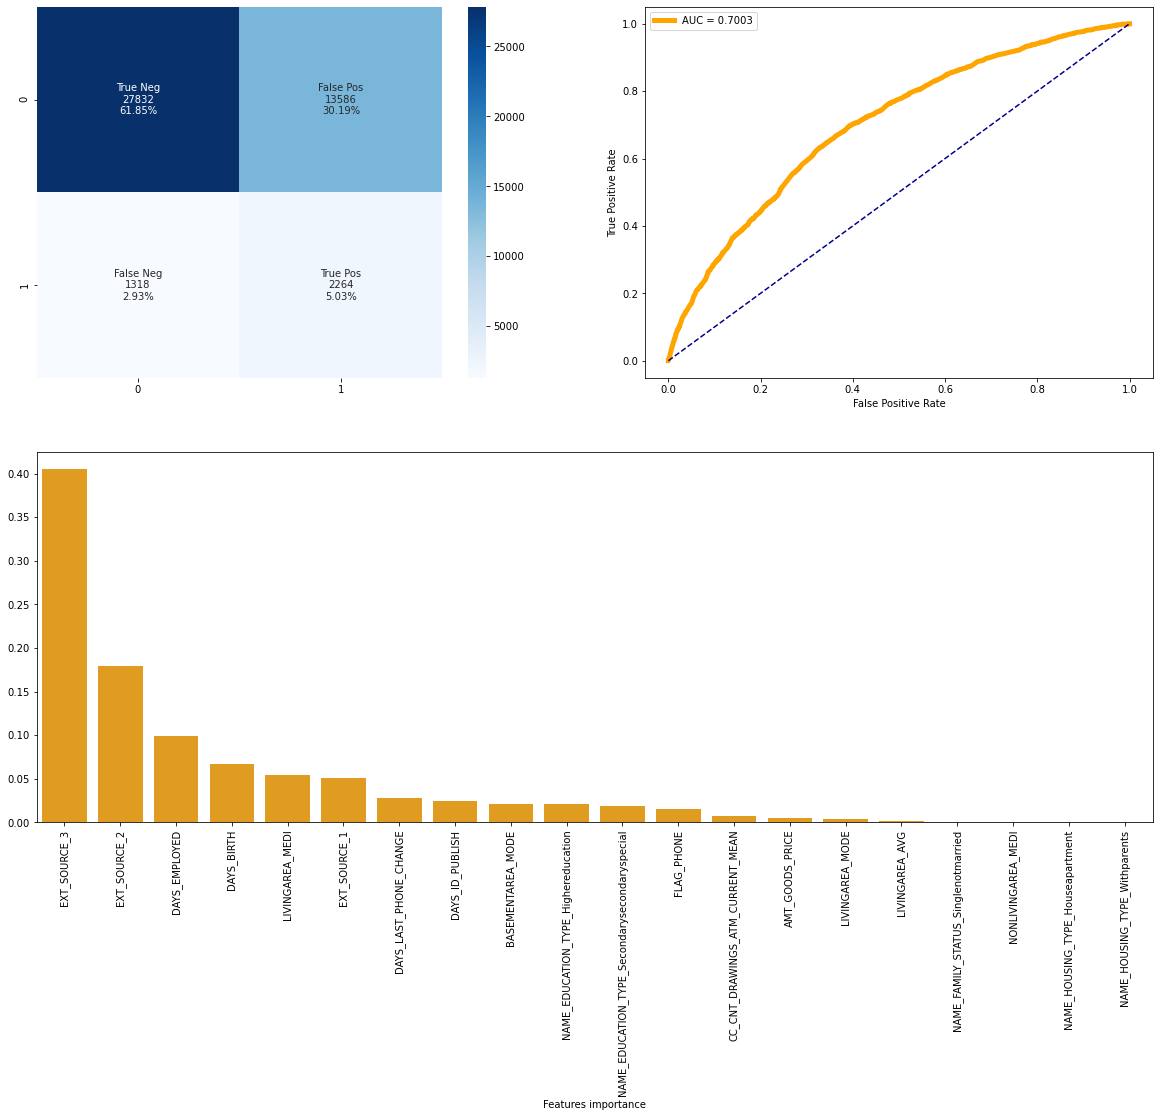

In [218]:
cf_matrix_roc_auc(model_rfc, y_test, model_rfc.predict(X_test), model_rfc.predict_proba(X_test)[:,1],feature_importances=True)

In [219]:
train_models(model_rfc, X_train_rus, X_test, y_train_rus, y_test)

{'AUC': 0.7003378811312074,
 'Accuracy': 0.6688,
 'Precision': 0.1428391167192429,
 'Recall': 0.6320491345616974,
 'F1': 0.23301770275833678}

## INTERPRÉTABILITÉ DU MODÈLE ML

> L’interprétabilité est la mesure dans laquelle un humain peut comprendre les causes d’une décision (d’une prédiction) d’un modèle.

> "Les différents calculs d’importance de variables (features importance), en particulier pour les modèles de forêt aléatoire (random forest) et xgboost, pour lesquels les librairies Python sklearn et xgboost (respectivement) proposent de base plusieurs calculs. Nous allons cependant montrer leurs limites, et pourquoi il vaut mieux utiliser la permutation importance ou SHAP. Nous montrerons ensuite différents graphiques de la librairie SHAP permettant d’analyser les prédictions d’un modèle." source: https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/


### Global

In [63]:
feats = list(X_train.columns)

In [64]:
explainer = shap.TreeExplainer(model_rfc,X_train_rus)

In [65]:
shap_values = explainer.shap_values(X_test,check_additivity=False)

In [82]:
shap_values_test = explainer.shap_values(X_test.values)
shap_values_train = explainer.shap_values(X_train.values)

100%|===================| 209419/209994 [00:17<00:00]        

In [67]:
shap_expl = explainer(X_test,check_additivity=False)

### Pour les graphiques "summary_plot" (1 graphique par classe) :

>SHAP permet de calculer, pour chaque donnée, l’importance de chaque variable. Il suffit de faire la moyenne des importances afin d’avoir des importances « globales » pour chaque variable

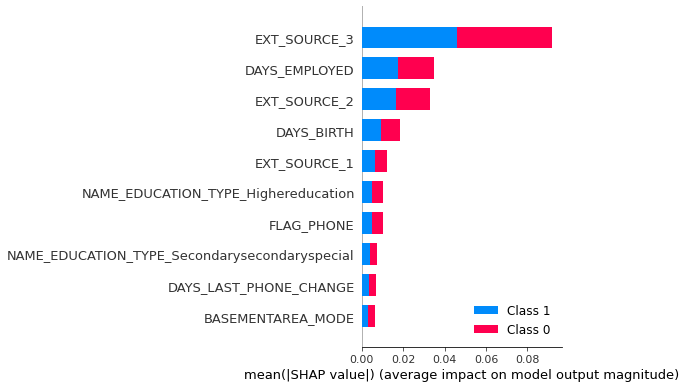

In [68]:
shap.summary_plot(shap_values,feature_names=feats,max_display=10)

> Cependant, l’énorme avantage de SHAP est que la technique permet d’avoir une information plus précise pour chaque donnée. Voir graphiques ci dessous pour chaque classe.

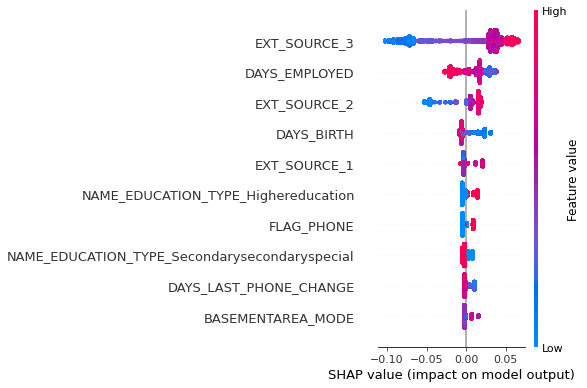

In [69]:
shap.summary_plot(shap_values[0], X_test,max_display=10)

>Ici, chaque point correspond à une donnée (de test). Les valeurs SHAP (abscisse) sont représentées pour chaque variable (ordonnée), pour chaque donnée. La couleur représente la valeur de la variable. Des « épaisseurs » plus importantes sur l’axe des ordonnées (par exemple pour la variable DAYS_BIRTH en abscisse 0) permettent de représenter une densité de points plus importante.
>Sur ce graphique qui correspond à la **classe 0**, on comprend donc qu’un EXT_SOURCE_3 élevée rend la possibilité qu'une personne ne rencontre pas de difficultés pour payer son prêt (car une valeur SHAP élevée, donc une appartenance plus forte à la classe 0), alors qu’être passé au collège ("NAME_EDUCATION_TYPE_Secondarysecondaryspecial") ne rend pas plus possible q'une personne ne rencontre pas de difficulté à payer son prêt.

>Pour le graphique de la **classe 1** (suivant), « qui rend la possibilité qu'une personne rencontre des difficultés à rembourser son prêt » **on obtient un graphique presque inverse** :

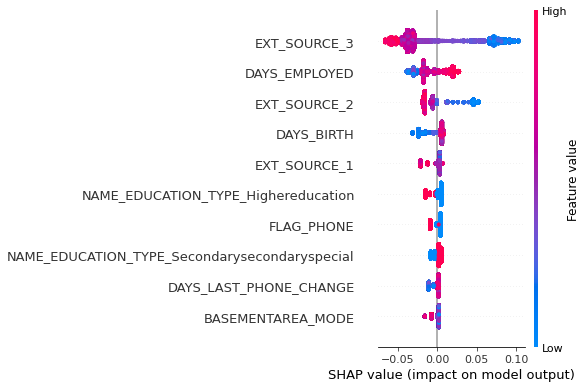

In [70]:
shap.summary_plot(shap_values[1], X_test,max_display=10)

### Local

In [71]:
num_index = X_test.index

In [72]:
i = num_index[0]
choosen_instance = X_test.loc[[i]]

In [73]:
shap_test = explainer.shap_values(choosen_instance)

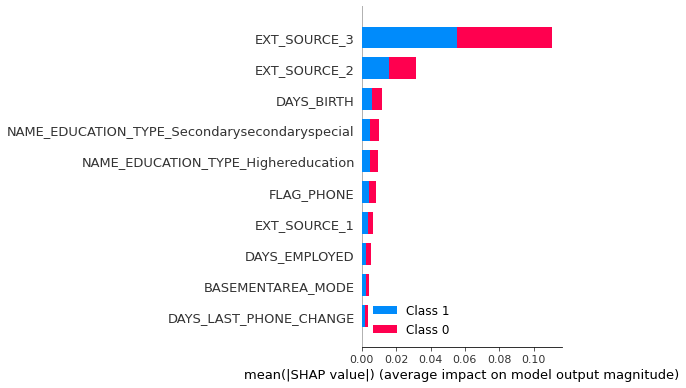

In [74]:
shap.summary_plot(shap_test,choosen_instance,max_display=10)

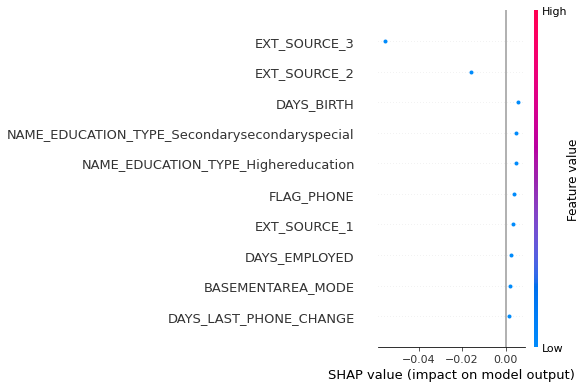

In [75]:
shap.summary_plot(shap_test[1],choosen_instance,max_display=10)

## Force_plot : graphique pour une donnée
### On peut voir les influences de chaque variable sur la prédiction.

In [100]:
def shap_multiclass(idx, data='train'):
    if data=='train':
        y = y_train
        X = X_train
        shap_values = shap_values_train
    elif data=='test':
        y = y_test
        X = X_test
        shap_values = shap_values_test
    #idx = X.index[idx]
    print (idx)
    print ("y réel : "+str(y.iloc[idx]))
    print ("y prédit : "+str(model_rfc.predict(X.iloc[idx, :].values.reshape(1, -1))))
    for i in [0,1]:
        print (f'classe {i}')
        display(shap.force_plot(explainer.expected_value[i], shap_values[i][idx, :], X.iloc[idx, :]))

In [88]:
shap_multiclass(50,'train')

50
y réel : 0.0
y prédit : [1.]
classe 0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


classe 1


#### Données d'entrainement
- La valeur de base (base value) est la valeur moyenne obtenue comme sortie pour cette classe, alors que la valeur de sortie (model output value) est la valeur prédite par le modèle. Les valeurs SHAP de chaque variable, proportionnelles aux tailles des flèches, « poussent » la prédiction depuis la valeur de base jusqu’à la valeur prédite. 
> Ainsi, dans le cas de la **classe 0**, la valeur de la variable **EXT_SOURCES_3** est déterminante pour dire que la donnée appartient à la classe 0, alors que la valeur d'**EXT_SOURCES_3** qui permet de dire que la donnée n’appartient pas à la classes 1.

In [89]:
shap_multiclass(20,'test')

20
y réel : 0.0
y prédit : [1.]
classe 0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


classe 1


#### Données de test
> Même observation qu'avec les données d'entraînement
> Ainsi, dans le cas de la **classe 0**, la valeur de la variable **EXT_SOURCES_3** est déterminante pour dire que la donnée appartient à la classe 0, alors que la valeur d'**EXT_SOURCES_3** qui permet de dire que la donnée n’appartient pas à la classes 1.

## Decision_plot : montre comment un modèle arrive à la décision:

>La model output value est cette fois la valeur moyenne des output values pour les différentes classes, et où les valeurs SHAP sont décalées afin de correctement reproduire le score de sortie du modèle. On peut ainsi facilement comparer les effets des variables sur les prédictions des différentes classes.

>Le decision_plot permet d’afficher les mêmes informations que le force_plot sous un autre format. Par exemple, pour la même donnée que précédemment, pour la classe 0 :

In [108]:
# Create the first plot, returning the plot structures.
#shap.decision_plot(expected_value, shap_values, features_display, return_objects=True)

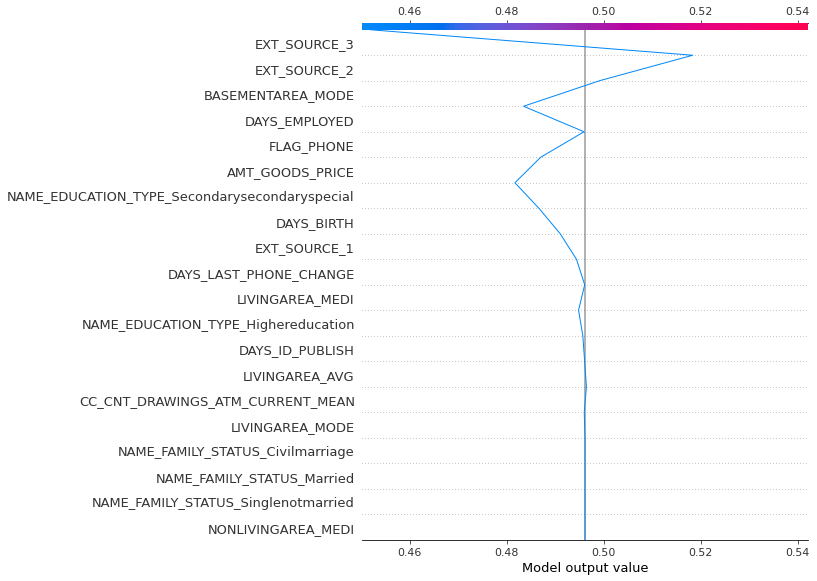

In [97]:
shap.decision_plot(explainer.expected_value[0], shap_values_test[0][idx, :], feats, feature_order=r.feature_idx)

> Pour la classe 1 :

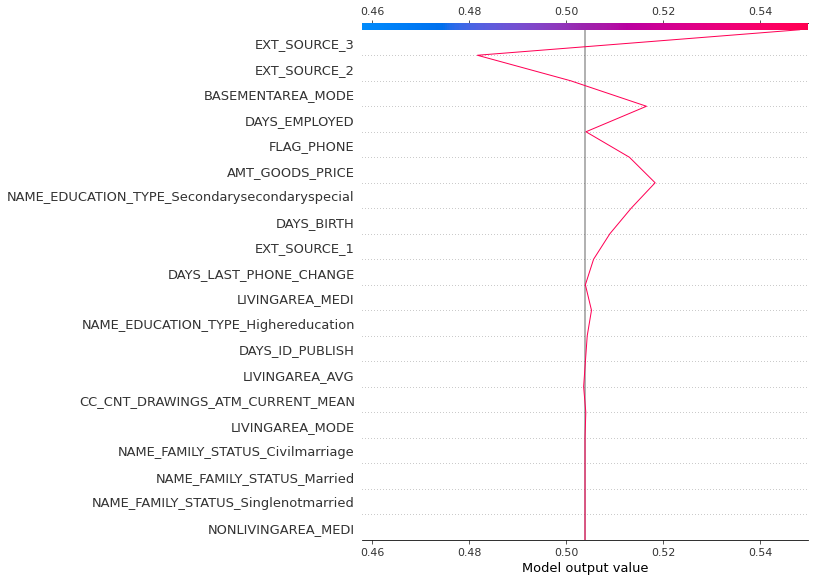

In [98]:
shap.decision_plot(explainer.expected_value[1], shap_values_test[1][idx, :], feats, feature_order=r.feature_idx)

>Dans le cas multi-class, on peut afficher les informations sur les différentes classes sur un même graphique, pour UNE donnée :

> L’avantage de ce graphique est qu’il est possible d’afficher plusieurs courbes en même temps. Par exemple, dans le cas multi-classes, il est possible d’afficher les  valeurs SHAP pour les différentes classes avec le multioutput_decision_plot.
>La model output value est cette fois la valeur moyenne des output values pour les différentes classes, et les valeurs SHAP sont décalées afin de correctement reproduire le score de sortie du modèle. On peut ainsi facilement comparer les effets des variables sur les prédictions des différentes classes.

In [93]:
def class_labels(row_index):
    def pred(c):
        return model_rfc.predict_proba(X_test.iloc[row_index, :].values.reshape(1, -1))[0][c]
    return [f'Class {i} ({pred(i).round(2):.2f})' for i in range(2)]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


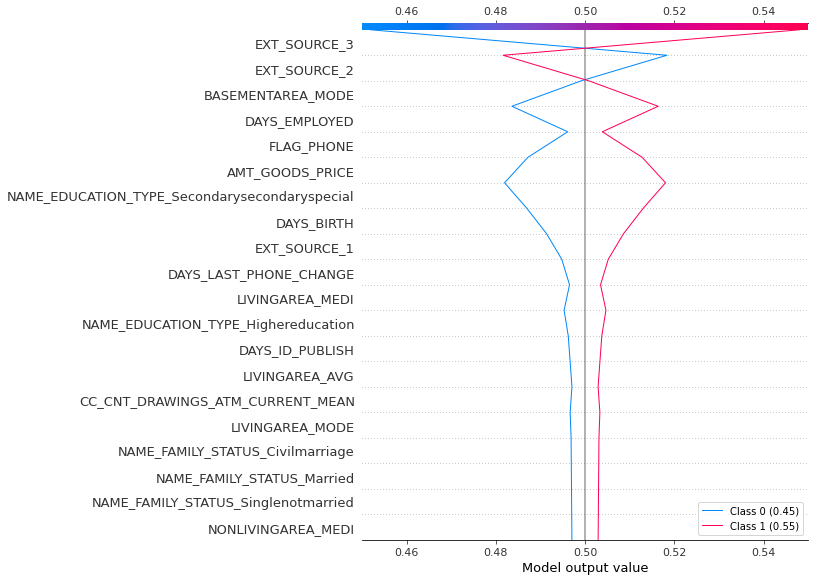

In [94]:
idx = 20
r = shap.multioutput_decision_plot(list(explainer.expected_value), shap_values_test, row_index=idx,
                               feature_names = feats,
                               legend_labels=class_labels(idx),
                               legend_location='lower right',
                                return_objects=True
                              )

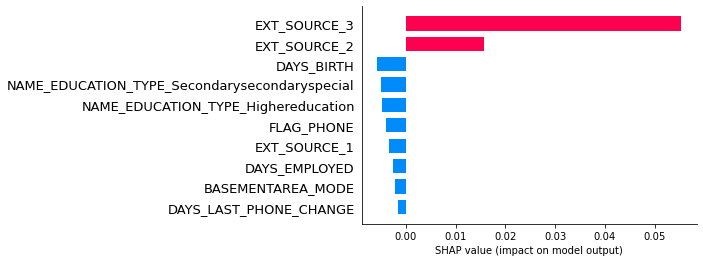

In [104]:
shap.bar_plot(shap_values[0][0],feature_names=choosen_instance.columns,max_display=10)

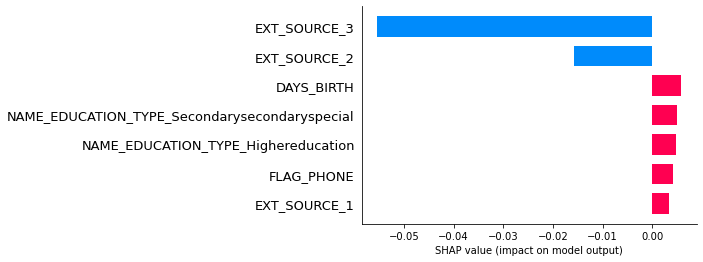

In [105]:
shap.bar_plot(shap_values[1][0],feature_names=choosen_instance.columns)

### Conclusion
> L’interprétabilité est un aspect métier important dans le processus de construction d’un modèle de Machine Learning dans des domaines assez réglementés. Il a différentes méthodes simples (permutation feature importance) et complexes (basées sur la valeur de Shapley). Cette dernière a été utilisée dans ce NoteBook.

## Prédiction

In [129]:
data_train['SK_ID_CURR'].unique()

array([100002, 100003, 100004, ..., 273886, 273887, 273888])

In [119]:
id_client = 100002
id_data_train = data_train[data_train['SK_ID_CURR']==id_client]
feats = list(X_train.columns)
id_predict = id_data_train[feats]

In [125]:
id_data_train

,TOTALAREA_MODE,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_DAYS_DECISION_MEAN,...,APPROVED_AMT_ANNUITY_MEAN,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,AMT_REQ_CREDIT_BUREAU_QRT,AMT_GOODS_PRICE,AMT_ANNUITY,ACTIVE_DAYS_CREDIT_MEAN,SK_ID_CURR,TARGET
0,0.0149,0.0,0.0,2.0,2.0,0.018801,0.0,1.0,12.333333,-670.666667,...,10358.685,0.0252,0.025,0.0247,0.0,351000.0,24700.5,-537.0,100002,1.0


In [120]:
id_predict

,TOTALAREA_MODE,REG_CITY_NOT_WORK_CITY,REG_CITY_NOT_LIVE_CITY,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,REGION_POPULATION_RELATIVE,PREV_PRODUCT_COMBINATION_CardStreet_MEAN,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_DAYS_DECISION_MEAN,...,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,APPROVED_AMT_ANNUITY_MEAN,APARTMENTS_MODE,APARTMENTS_MEDI,APARTMENTS_AVG,AMT_REQ_CREDIT_BUREAU_QRT,AMT_GOODS_PRICE,AMT_ANNUITY,ACTIVE_DAYS_CREDIT_MEAN
0,0.0149,0.0,0.0,2.0,2.0,0.018801,0.0,1.0,12.333333,-670.666667,...,0.0369,0.0369,10358.685,0.0252,0.025,0.0247,0.0,351000.0,24700.5,-537.0


In [127]:
prediction = model_rfc.predict(id_predict)

In [128]:
prediction

array([1.])

In [124]:
data_train.loc[data_train['SK_ID_CURR']==id_client,'TARGET']

0    1.0
Name: TARGET, dtype: float64

### Création de fichiers: pickle pour le modèle, .csv pour le jeu de donnée Train et explainer

In [100]:
import pickle

pickle_out = open('best_model.pkl','wb')
pickle.dump(best_model,pickle_out)
pickle_out.close()

In [263]:
X_train_sm.to_csv('X_train_rus.csv',index=False)

In [200]:
explainer.save(open('explainer', 'wb') , model_saver="auto", masker_saver="auto")